In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import re
from thefuzz import fuzz, process

import sys 
import os
sys.path.append(os.path.abspath("../src/"))
import metros

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
path = '../data/_data.csv'
df = pd.read_csv(path)

In [3]:
df.head()

,Unnamed: 0,ID объявления,Количество комнат,Тип,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,...,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление
0,0,271271157,4,Квартира,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",...,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157
1,1,271634126,4,Квартира,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",...,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126
2,2,271173086,"4, Оба варианта",Квартира,м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",...,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086
3,3,272197456,"4, Оба варианта",Квартира,м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...",...,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456
4,4,273614615,2,Квартира,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",...,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615


In [4]:
# Переименовываем колонки и убираем не нужные основываясь на EDA

In [5]:
df.set_index('ID  объявления', inplace=True)

In [6]:
df=df.drop(columns=["Unnamed: 0",'Телефоны','Описание','Площадь комнат, м2','Окна','Название ЖК','Серия дома',
                 'Мусоропровод','Ссылка на объявление', 'Тип'])
df=df.rename(columns={'ID  объявления':"ID",'Количество комнат':"numbers_rooms",'Метро':"metro",'Адрес':"address",'Площадь, м2':"area_square",
                     "Дом":"building","Парковка":"parking","Цена":"price","Ремонт":"repair","Балкон":"balcony","Санузел":"bathroom","Можно с детьми/животными":"with_child_and_dogs",
                      "Дополнительно":"comfort","Лифт":"elevator", 'Высота потолков, м': 'ceilings'})

In [7]:
df.head()

,numbers_rooms,metro,address,area_square,building,parking,price,repair,balcony,bathroom,with_child_and_dogs,comfort,ceilings,elevator
ID объявления,,,,,,,,,,,,,,
271271157,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",Дизайнерский,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...",3.0,"Пасс (4), Груз (1)"
271634126,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",Дизайнерский,NaN,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",3.5,"Пасс (1), Груз (1)"
271173086,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",Евроремонт,NaN,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",3.2,Пасс (1)
272197456,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...",Евроремонт,NaN,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",3.2,Пасс (1)
273614615,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",Евроремонт,NaN,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",3.9,"Пасс (1), Груз (1)"


In [8]:
# Делим колонку адрес на колонку Город и Адрес

In [9]:
df['city'] = df.loc[:,'address'].str.split(',').str[0]
df['address'] = df.loc[:,'address'].str.split(',').str[1] + df.loc[:,'address'].str.split(',').str[2]

In [10]:
# Удаляем все не московские объявления

In [11]:
df = df.loc[df.loc[:,'city'] == 'Москва']

In [12]:
# Удаляем колонку город, теперь она не нужна

In [13]:
df.drop(columns=['city'], inplace=True)

In [14]:
# Заполняем пустые значения дети/животные, парковки, балконов, лифтов значением НЕТ (посмотреть на графиках как будет)

In [15]:
df['parking'] = df['parking'].fillna('нет парковки')

In [16]:
df.drop(df.loc[df.loc[:,'parking'].str.contains('на крыше')].index, inplace=True) # всего одно значение

In [17]:
df['parking'] = df['parking'].astype('category')

In [18]:
df['balcony'] = df['balcony'].fillna('нет балкона').astype('category')

In [19]:
df['elevator'] = df['elevator'].fillna('нет лифта').astype('category')

In [20]:
df['with_child_and_dogs'] = df['with_child_and_dogs'].fillna('без детей и животных').astype('category')

In [21]:
# Сегментизируем колонку комфорт

In [22]:
def categorize_items(comf):
    if pd.isna(comf):
        return pd.NA
    items = comf.split(', ')
    count = len(items)

    if count <= 3:
        return 'простой'
    elif 4 <= count <= 6:
        return 'стандарт'
    elif 7 <= count <= 9:
        return 'комфорт'
    else:
        return 'премиум'

df['comfort_cat'] = df['comfort'].apply(categorize_items)

In [23]:
totals = df['comfort_cat'].value_counts().head(4).sum()
missings = df['comfort_cat'].isna().sum()
for val, count in zip((df['comfort_cat'].value_counts().head(4) / totals * missings).index, round(df['comfort_cat'].value_counts().head(4) / totals * missings).to_numpy()):
    df['comfort_cat'] = df['comfort_cat'].fillna(val, limit=int(count))

In [24]:
# Удаляем старую колонку комфорт

In [25]:
df.drop(columns=['comfort'], inplace=True)

In [26]:
# С помощью алгоритма сравнения строк Levenshtein заполняем пустые значения метро
# Находим наиболее близкие строки адресов с заполненым метро и берем метро оттуда

In [27]:
# Подготовка переменнх
strip = np.vectorize(str.strip)
addresses = strip(df.loc[df.loc[:,'metro'].notna()]['address'].unique())
temp_df = df.loc[df.loc[:,'metro'].notna(), ['address', 'metro']]


In [28]:
def fill_metro(row):
    # применяем алгоритм, что бы найти максимально близкую строка адреса с метро
    address = max(addresses, key=lambda x: fuzz.partial_ratio(row['address'], x))
    return(temp_df[temp_df.loc[:,'address'].str.contains(address)]['metro'].mode()[0]) #возвращаем mode метро данного адреса

df['metro'] = pd.concat([
    df[df.loc[:,'metro'].isna()].apply(fill_metro, axis=1),
    df.loc[df.loc[:,'metro'].notna(), 'metro']
])

In [29]:
# Будем отслеживать местоположение теперь по метро, избавимся от колонки адреси

In [30]:
df.drop(columns=['address'], inplace=True)

In [31]:
# Обрабатываем колонку площади и приводим к числовому типу

In [32]:
df['area_square'] = pd.to_numeric(df['area_square'].map(lambda x: x.split('/')[0])).astype(int)

In [33]:
# Делим колонку метро на: название метро, время пути, транспорт

In [34]:
df[["metro_station", "time_min", "method"]] = df["metro"].str.extract(r'м\.\s*([^(]+)\s*\((\d+|None)\s*мин\s+(пешком|на машине)\)')
df["time_min"]=pd.to_numeric(df["time_min"], errors='coerce')
df['time_min'] = df["time_min"].fillna(0)

mean = df['time_min'].mean()
station_means = df.groupby('metro_station')['time_min'].mean().to_dict()

def replace_zero_with_mean(row):
    if row['time_min'] == 0:
        mean_time = station_means.get(row['metro_station'], mean)
        return mean_time if not pd.isna(mean_time) else 0
    return row['time_min']
df['time_min'] = df.apply(replace_zero_with_mean, axis=1)

In [35]:
# метро лужники всего 1 значение, выкидываем его
df.drop(df.loc[df.loc[:,'metro_station'].str.contains('Лужники')].index, inplace=True)

In [36]:
# Избавляемся от колонки metro, эта информация есть в колонке metro_station

In [37]:
df.drop(columns=['metro'], inplace=True)

In [38]:
# Обрабатываем колонку цены и приводим к числовому типу

In [39]:
def calculate_total(price_str):
    if not isinstance(price_str, str):
        return 0  

    total_cost = 0

    rent_match = re.search(r'([\d.,]+)\sруб./ За месяц', price_str)
    if rent_match:
        rent = float(rent_match.group(1).replace(',', '.'))  
        total_cost += rent

    utility_match = re.search(r'Сумма коммунальных платежей - ([\d.,]+)\sруб.', price_str)
    if utility_match:
        utility = float(utility_match.group(1).replace(',', '.'))  
        total_cost += utility

    dollar_match = re.search(r'([\d.,]+)\s\$', price_str)
    if dollar_match:
        dollars = float(dollar_match.group(1).replace(',', '.')) 
        total_cost += dollars * 85  

    euro_match = re.search(r'([\d.,]+)\s€', price_str)
    if euro_match:
        euros = float(euro_match.group(1).replace(',', '.'))  
        total_cost += euros * 95  

    return int(round(total_cost))

df['price'] = df.loc[:,'price'].apply(calculate_total)

In [40]:
# Заполняем пропущенные значения в колонке высота потолков, значениями из топ 20 по частоте встречи, в нужном соотношении

In [41]:
totals = df['ceilings'].value_counts().head(20).sum()
missings = df['ceilings'].isna().sum()
for val, count in zip((df['ceilings'].value_counts().head(20) / totals * missings).index, round(df['ceilings'].value_counts().head(20) / totals * missings).to_numpy()):
    df['ceilings'] = df['ceilings'].fillna(val, limit=int(count))

In [42]:
# Добавляем новую колонку административный округ

In [43]:
def set_district(metro):
    metro = metro.strip()
    district = None
    if metro in metros.VAO:
        district = 'VAO'
    elif metro in metros.ZAO:
        district = 'ZAO'
    elif metro in metros.NAO:
        district = 'NAO'
    elif metro in metros.SAO:
        district = 'SAO'
    elif metro in metros.SVAO:
        district = 'SVAO'
    elif metro in metros.SZAO:
        district = 'SZAO'
    elif metro in metros.CAO:
        district = 'CAO'
    elif metro in metros.UVAO:
        district = 'UVAO'
    elif metro in metros.UZAO:
        district = 'UZAO'
    elif metro in metros.UAO:
        district = 'UAO'
    elif metro in metros.RAYONI:
        district = 'RAYONI'

    return district
        

df['district'] = df['metro_station'].map(set_district)
df['district'] = df['district'].astype('category')

In [44]:
# Колонка метро нам больше не нужна, удаляем ее

In [45]:
df.drop(columns=['metro_station'], inplace=True)

In [46]:
# Обрабатываем колонку с количеством комнат, заполняем пробелы и приводим ее к цифровой

In [47]:
def numbers(num):
    if pd.isna(num):
        return np.nan
    if len(num)>2:
        word=num.split(",")
        numb=word[0].strip()
    else:
        numb=str(num).strip()
    return numb

df["numbers_rooms"]=df["numbers_rooms"].apply(numbers)

In [48]:
totals = df['numbers_rooms'].value_counts().head(6).sum()
missings = df['numbers_rooms'].isna().sum()
for val, count in zip((df['numbers_rooms'].value_counts().head(6) / totals * missings).index, round(df['numbers_rooms'].value_counts().head(6) / totals * missings).to_numpy()):
    df['numbers_rooms'] = df['numbers_rooms'].fillna(val, limit=int(count))

In [49]:
df.drop(df.loc[df['numbers_rooms'].isna()].index, inplace=True) #УБираем 1 NaN значение комнат, погрешность алгоритма
df['numbers_rooms'] = pd.to_numeric(df['numbers_rooms'])

In [50]:
# Объединяем колонки time_min и method в одну - пешая доступность

In [51]:
def walking_dist(row):
    time = row['time_min']
    time = time * 3 if row['method'] == 'на машине' else time

    return time <= 11 #подходит лучше всего

df['walking_dist'] = df.loc[:, ['method', 'time_min']].apply(walking_dist, axis=1)

In [52]:
df['walking_dist'].sum()

np.int64(11975)

In [53]:
# колонки time_min и  method больше не нужны, убираем их

In [54]:
df.drop(columns=['time_min', 'method'], inplace=True)

In [55]:
# Заполняем пропуски в колонке ремонт

In [56]:
totals = df['repair'].value_counts().head(4).sum()
missings = df['repair'].isna().sum()
for val, count in zip((df['repair'].value_counts().head(4) / totals * missings).index, round(df['repair'].value_counts().head(4) / totals * missings).to_numpy()):
    df['repair'] = df['repair'].fillna(val, limit=int(count))

In [57]:
df['repair'] = df['repair'].astype('category')

In [58]:
# Заполняем пропуски в колонке bathroom и убираем цифры

In [59]:
df['bathroom'] = df['bathroom'].str.replace(r'\(\d+\)', '', regex=True) #Убираем цифры

In [60]:
totals = df['bathroom'].value_counts().head(3).sum()
missings = df['bathroom'].isna().sum()
for val, count in zip((df['bathroom'].value_counts().head(3) / totals * missings).index, round(df['bathroom'].value_counts().head(3) / totals * missings).to_numpy()):
    df['bathroom'] = df['bathroom'].fillna(val, limit=int(count))

In [61]:
df['bathroom'].value_counts(dropna=False)

bathroom
Совмещенный                  11251
Раздельный                    7360
Совмещенный , Раздельный      1123
Name: count, dtype: int64

In [62]:
# Делаем 2 колонки, начилие совмещенного и раздельного санузлов

In [63]:
df['bath_comb'] = df['bathroom'].str.contains('Совмещенный')
df['bath_sep'] = df['bathroom'].str.contains('Раздельный')

In [64]:
# Убираем прошлую колонку bathroom

In [65]:
# Разбираемся с колонкой балкона

In [66]:
df['balcony'] = df['balcony'].str.replace(r'\(\d+\)', '', regex=True) #Убираем цифры

In [67]:
df['loggia'] = df['balcony'].str.contains('Лоджия')
df['balcony'] = df['balcony'].str.contains('Балкон')

In [68]:
df.drop(columns=['bathroom'], inplace=True)

In [69]:
# Разбираемся с колонкой дома

In [70]:
df['elevator'] = df['elevator'].str.replace(r'\(\d+\)', '', regex=True) #Убираем цифры
df['elev_pass'] = df['elevator'].str.contains('Пасс')
df['elev_cargo'] = df['elevator'].str.contains('Груз')

In [71]:
df.drop(columns=['elevator'], inplace=True)

In [72]:
# Делим колонку build на 3 колонки

In [73]:
df[["floor","quant_floor"]] = df["building"].str.split("/",expand=True)
df[["max_floor","type_house"]] = df["quant_floor"].str.split(",",expand=True)
df["cur_floor"] = df["floor"].astype(int)
df["max_floor"] = df["max_floor"].astype(int)

In [74]:
df=df.drop(["quant_floor","building", 'floor'],axis=1)

In [75]:
df.drop(df[df['cur_floor'] < 1].index) # удаляем объявление с этажом меньше 1

,numbers_rooms,area_square,parking,price,repair,balcony,with_child_and_dogs,ceilings,comfort_cat,district,walking_dist,bath_comb,bath_sep,loggia,elev_pass,elev_cargo,max_floor,type_house,cur_floor
ID объявления,,,,,,,,,,,,,,,,,,,
271271157,4,200,подземная,500000,Дизайнерский,False,"Можно с детьми, Можно с животными",3.00,премиум,CAO,True,True,False,False,True,True,16,Монолитный,5
271634126,4,198,подземная,500000,Дизайнерский,False,Можно с детьми,3.50,премиум,CAO,True,True,True,False,True,True,16,Монолитно-кирпичный,5
271173086,4,200,подземная,500000,Евроремонт,False,Можно с детьми,3.20,премиум,CAO,True,True,False,False,True,False,16,None,5
272197456,4,170,подземная,400000,Евроремонт,False,Можно с животными,3.20,премиум,CAO,True,True,False,False,True,False,6,None,5
273614615,2,58,нет парковки,225000,Евроремонт,False,без детей и животных,3.90,комфорт,CAO,True,True,False,False,True,True,26,Панельный,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274652877,6,25,нет парковки,39000,Евроремонт,False,без детей и животных,3.40,комфорт,NAO,True,True,True,False,True,True,17,Монолитный,11
274654844,1,38,нет парковки,45000,Евроремонт,False,без детей и животных,3.40,стандарт,ZAO,True,True,False,True,True,True,18,Монолитный,5
268679909,2,43,нет парковки,50000,Дизайнерский,True,Можно с детьми,3.40,стандарт,ZAO,True,True,False,False,False,False,5,Кирпичный,5


In [76]:
# Заполняем пустые значения в типе дома

In [77]:
totals = df['type_house'].value_counts().head(7).sum()
missings = df['type_house'].isna().sum()
for val, count in zip((df['type_house'].value_counts().head(7) / totals * missings).index, round(df['type_house'].value_counts().head(7) / totals * missings).to_numpy()):
    df['type_house'] = df['type_house'].fillna(val, limit=int(count))

In [78]:
# Избавляемся от значений 'деревянный' и 'щитовой' их крайне мало

In [79]:
df.drop(df.loc[df['type_house'].isna()].index, inplace=True) #УБираем 1 NaN значение комнат, погрешность алгоритма
df.drop(df.loc[df['type_house'].str.contains('Деревянный')].index, inplace=True)
df.drop(df.loc[df['type_house'].str.contains('Щитовой')].index, inplace=True)

In [80]:
df['type_house'] = df['type_house'].astype('category')

In [81]:
# Проверяем остались ли NaN значения

In [82]:
df.isna().sum()

numbers_rooms          0
area_square            0
parking                0
price                  0
repair                 0
balcony                0
with_child_and_dogs    0
ceilings               0
comfort_cat            0
district               0
walking_dist           0
bath_comb              0
bath_sep               0
loggia                 0
elev_pass              0
elev_cargo             0
max_floor              0
type_house             0
cur_floor              0
dtype: int64

In [83]:
# Проверяем тип данных

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19727 entries, 271271157 to 274672243
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   numbers_rooms        19727 non-null  int64   
 1   area_square          19727 non-null  int64   
 2   parking              19727 non-null  category
 3   price                19727 non-null  int64   
 4   repair               19727 non-null  category
 5   balcony              19727 non-null  bool    
 6   with_child_and_dogs  19727 non-null  category
 7   ceilings             19727 non-null  float64 
 8   comfort_cat          19727 non-null  object  
 9   district             19727 non-null  category
 10  walking_dist         19727 non-null  bool    
 11  bath_comb            19727 non-null  bool    
 12  bath_sep             19727 non-null  bool    
 13  loggia               19727 non-null  bool    
 14  elev_pass            19727 non-null  bool    
 15  elev_cargo  

In [85]:
# Смотрим на данные

In [86]:
df.head()

,numbers_rooms,area_square,parking,price,repair,balcony,with_child_and_dogs,ceilings,comfort_cat,district,walking_dist,bath_comb,bath_sep,loggia,elev_pass,elev_cargo,max_floor,type_house,cur_floor
ID объявления,,,,,,,,,,,,,,,,,,,
271271157,4,200,подземная,500000,Дизайнерский,False,"Можно с детьми, Можно с животными",3.0,премиум,CAO,True,True,False,False,True,True,16,Монолитный,5
271634126,4,198,подземная,500000,Дизайнерский,False,Можно с детьми,3.5,премиум,CAO,True,True,True,False,True,True,16,Монолитно-кирпичный,5
271173086,4,200,подземная,500000,Евроремонт,False,Можно с детьми,3.2,премиум,CAO,True,True,False,False,True,False,16,Панельный,5
272197456,4,170,подземная,400000,Евроремонт,False,Можно с животными,3.2,премиум,CAO,True,True,False,False,True,False,6,Панельный,5
273614615,2,58,нет парковки,225000,Евроремонт,False,без детей и животных,3.9,комфорт,CAO,True,True,False,False,True,True,26,Панельный,12


In [87]:
# Убираем выбросы

In [88]:
df = df.loc[df['price'].between(27_000, 400_000)]

In [89]:
## Рисуем Графики

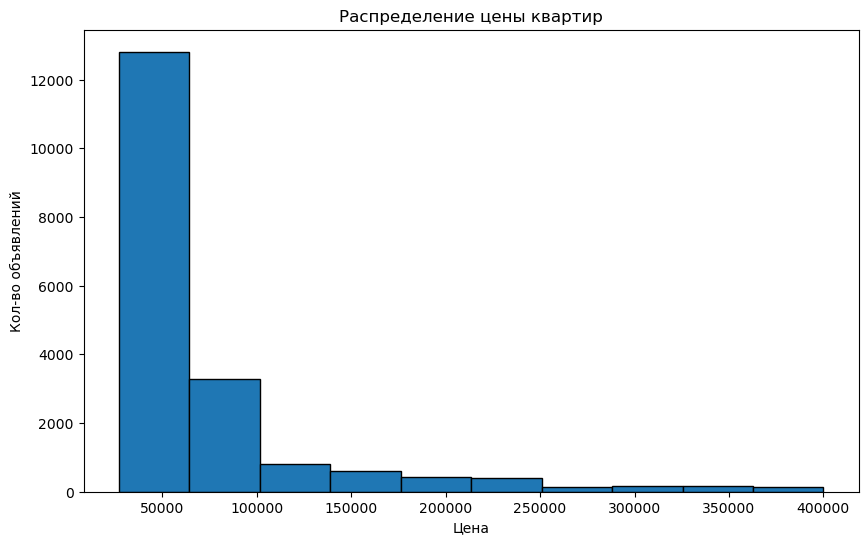

In [90]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(df['price'], bins=10, edgecolor='black')

ax.set_title('Распределение цены квартир')
ax.set_xlabel('Цена')
ax.set_ylabel('Кол-во объявлений')

plt.show();

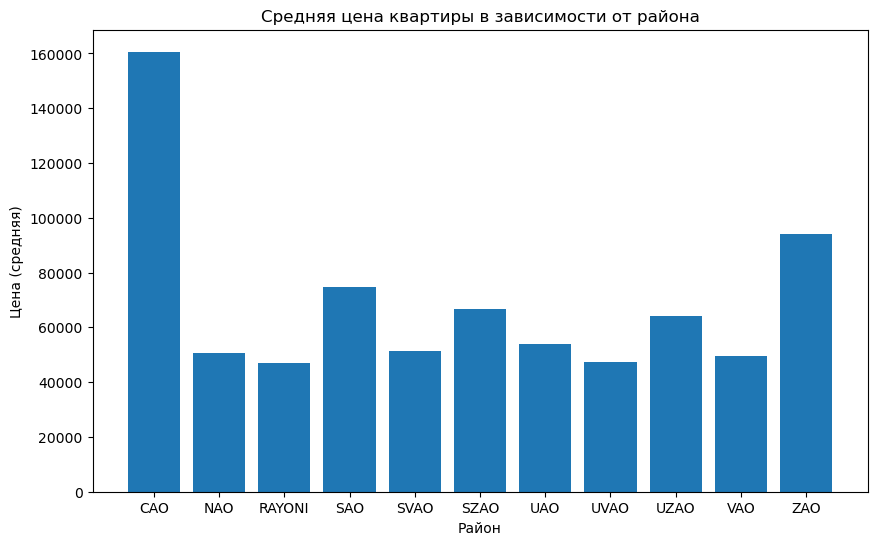

In [91]:
district_price = df.groupby('district')['price'].mean()
fig, ax = plt.subplots(figsize=(10,6))

plt.bar(district_price.index, district_price)

ax.set_title('Средняя цена квартиры в зависимости от района')
ax.set_xlabel('Район')
ax.set_ylabel('Цена (средняя)')

plt.show();

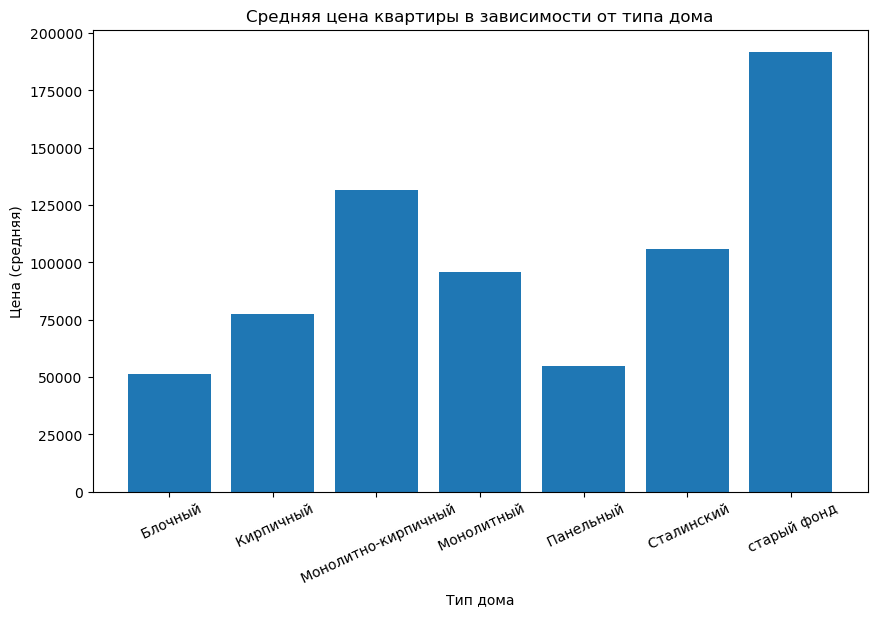

In [92]:
type_price = df.groupby('type_house')['price'].mean()
fig, ax = plt.subplots(figsize=(10,6))

plt.bar(type_price.index, type_price)

ax.set_title('Средняя цена квартиры в зависимости от типа дома')
ax.set_xlabel('Тип дома')
ax.set_ylabel('Цена (средняя)')

plt.xticks(rotation=25)
plt.show();

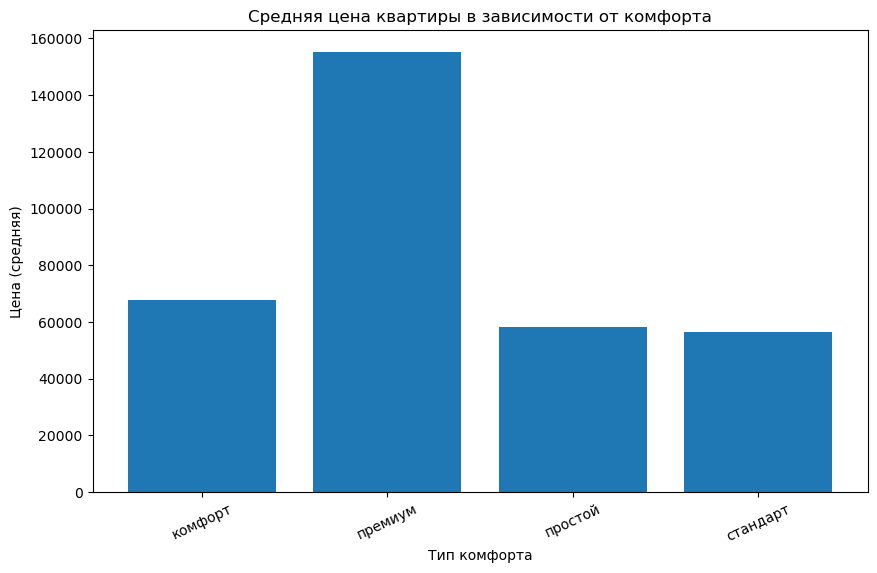

In [93]:
comfort_price = df.groupby('comfort_cat')['price'].mean()
fig, ax = plt.subplots(figsize=(10,6))

plt.bar(comfort_price.index, comfort_price)

ax.set_title('Средняя цена квартиры в зависимости от комфорта')
ax.set_xlabel('Тип комфорта')
ax.set_ylabel('Цена (средняя)')

plt.xticks(rotation=25)
plt.show();

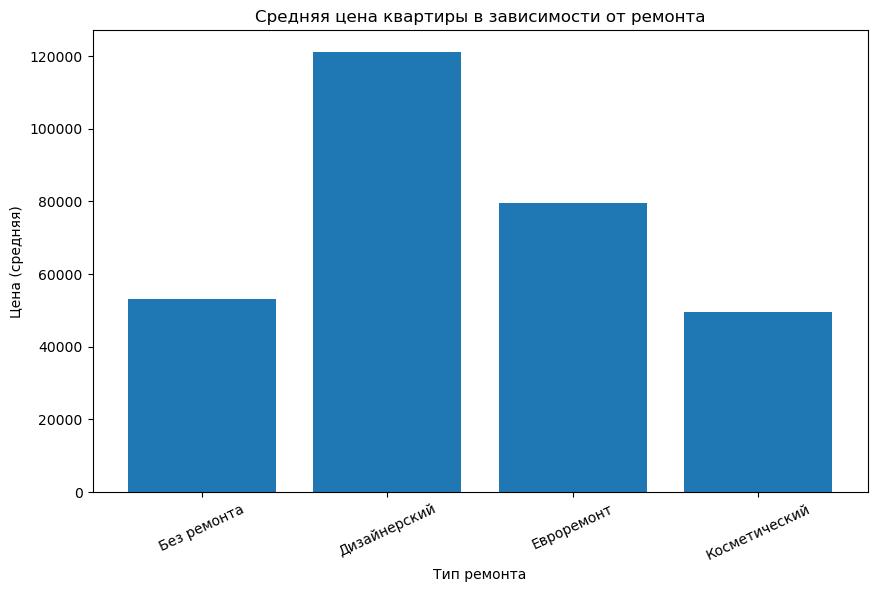

In [94]:
repair_price = df.groupby('repair')['price'].mean()
fig, ax = plt.subplots(figsize=(10,6))

plt.bar(repair_price.index, repair_price)

ax.set_title('Средняя цена квартиры в зависимости от ремонта')
ax.set_xlabel('Тип ремонта')
ax.set_ylabel('Цена (средняя)')

plt.xticks(rotation=25)
plt.show();

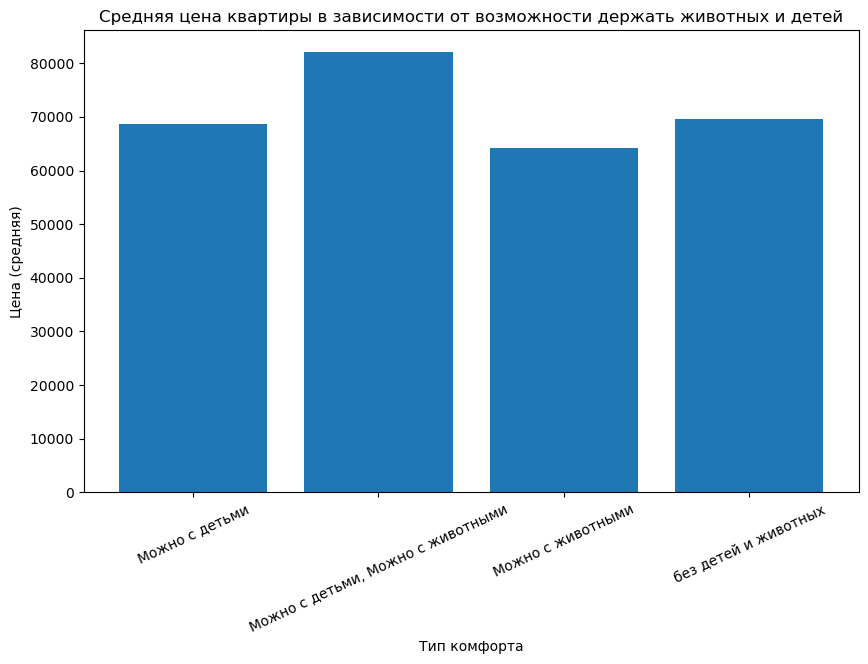

In [95]:
chd_price = df.groupby('with_child_and_dogs')['price'].mean()
fig, ax = plt.subplots(figsize=(10,6))

plt.bar(chd_price.index, chd_price)

ax.set_title('Средняя цена квартиры в зависимости от возможности держать животных и детей')
ax.set_xlabel('Тип комфорта')
ax.set_ylabel('Цена (средняя)')

plt.xticks(rotation=25)
plt.show();

In [96]:
# Меняем логику колонки комфорта

In [97]:
df['comfort_cat'] = df['comfort_cat'].str.contains('прем')

In [98]:
# Удаляем колонку детей и животных
df.drop(columns=['with_child_and_dogs'], inplace=True)

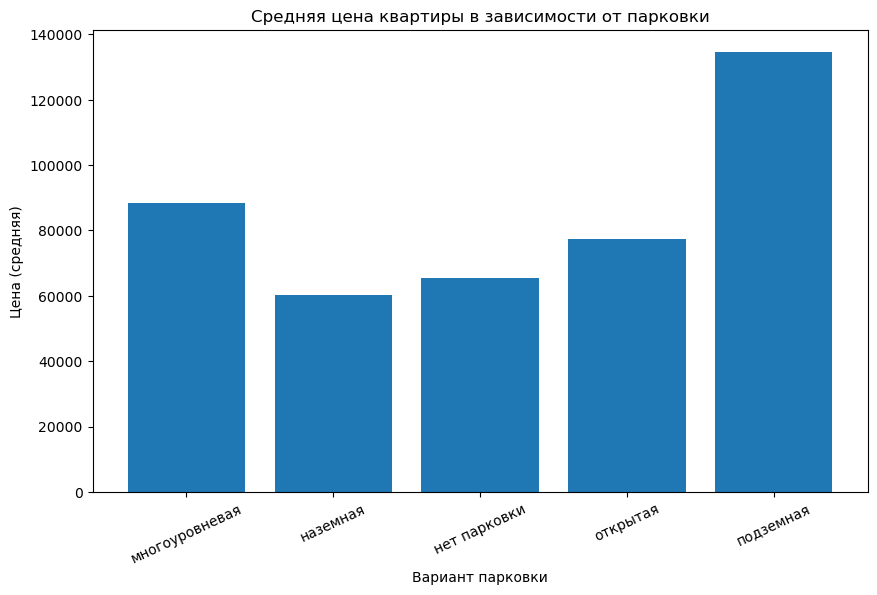

In [99]:
park_price = df.groupby('parking')['price'].mean()
fig, ax = plt.subplots(figsize=(10,6))

plt.bar(park_price.index, park_price)

ax.set_title('Средняя цена квартиры в зависимости от парковки')
ax.set_xlabel('Вариант парковки')
ax.set_ylabel('Цена (средняя)')

plt.xticks(rotation=25)
plt.show();

In [100]:
# Чистим от выбросов

In [101]:
df = df.loc[df['max_floor'].between(1, 79)]

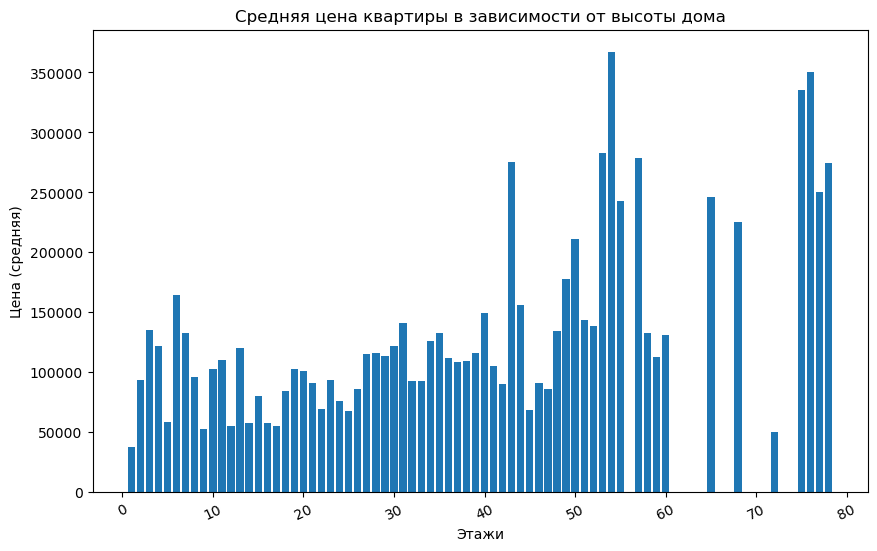

In [102]:
park_price = df.groupby('max_floor')['price'].mean()
fig, ax = plt.subplots(figsize=(10,6))

plt.bar(park_price.index, park_price)

ax.set_title('Средняя цена квартиры в зависимости от высоты дома')
ax.set_xlabel('Этажи')
ax.set_ylabel('Цена (средняя)')

plt.xticks(rotation=25)
plt.show();

In [103]:
df = df.loc[df['ceilings'].between(2, 4)]

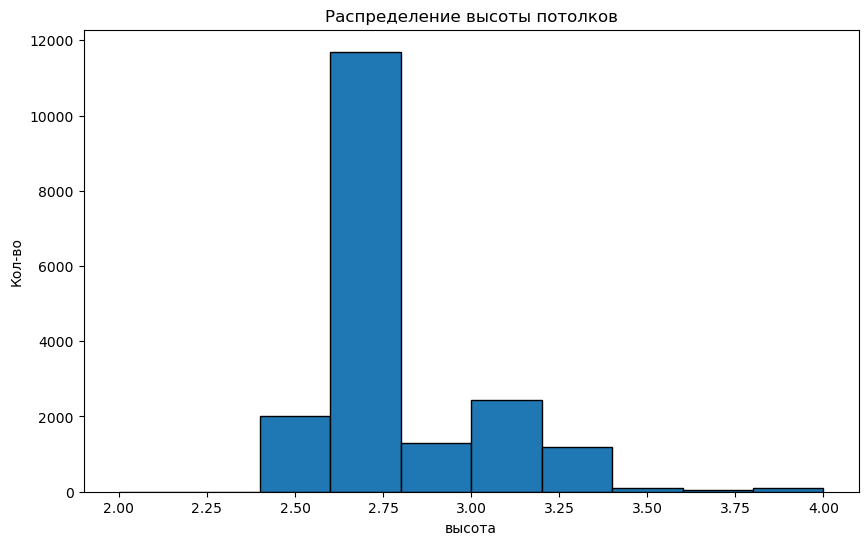

In [104]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(df['ceilings'], bins=10, edgecolor='black')

ax.set_title('Распределение высоты потолков')
ax.set_xlabel('высота')
ax.set_ylabel('Кол-во')

plt.show();

In [105]:
q1= df["area_square"].quantile(0.25)
q3= df["area_square"].quantile(0.75)
iqr=q3-q1
left=q1-3*iqr
right=q3+3*iqr
df=df.loc[df['area_square'].between(left, right)]

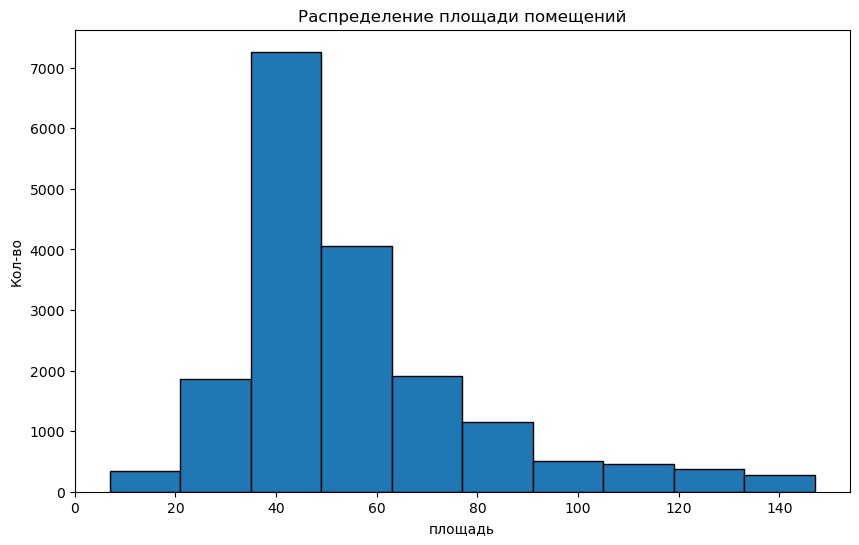

In [106]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(df['area_square'], bins=10, edgecolor='black')

ax.set_title('Распределение площади помещений')
ax.set_xlabel('площадь')
ax.set_ylabel('Кол-во')

plt.show();

<Axes: >

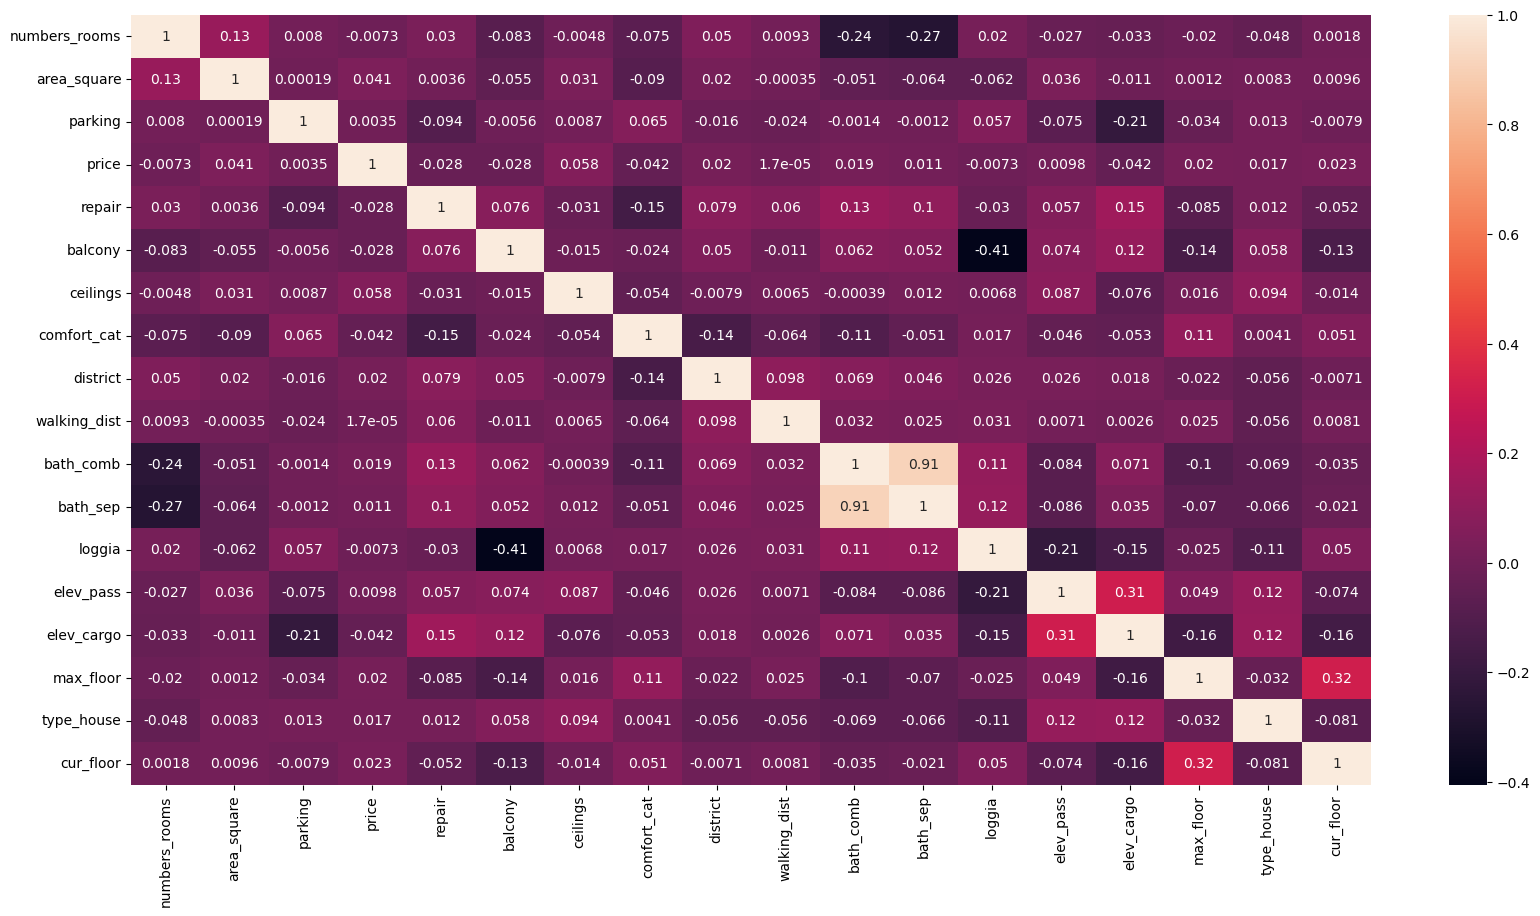

In [107]:
plt.figure(figsize=(20,10))
sns.heatmap(df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1), annot=True)

<Axes: >

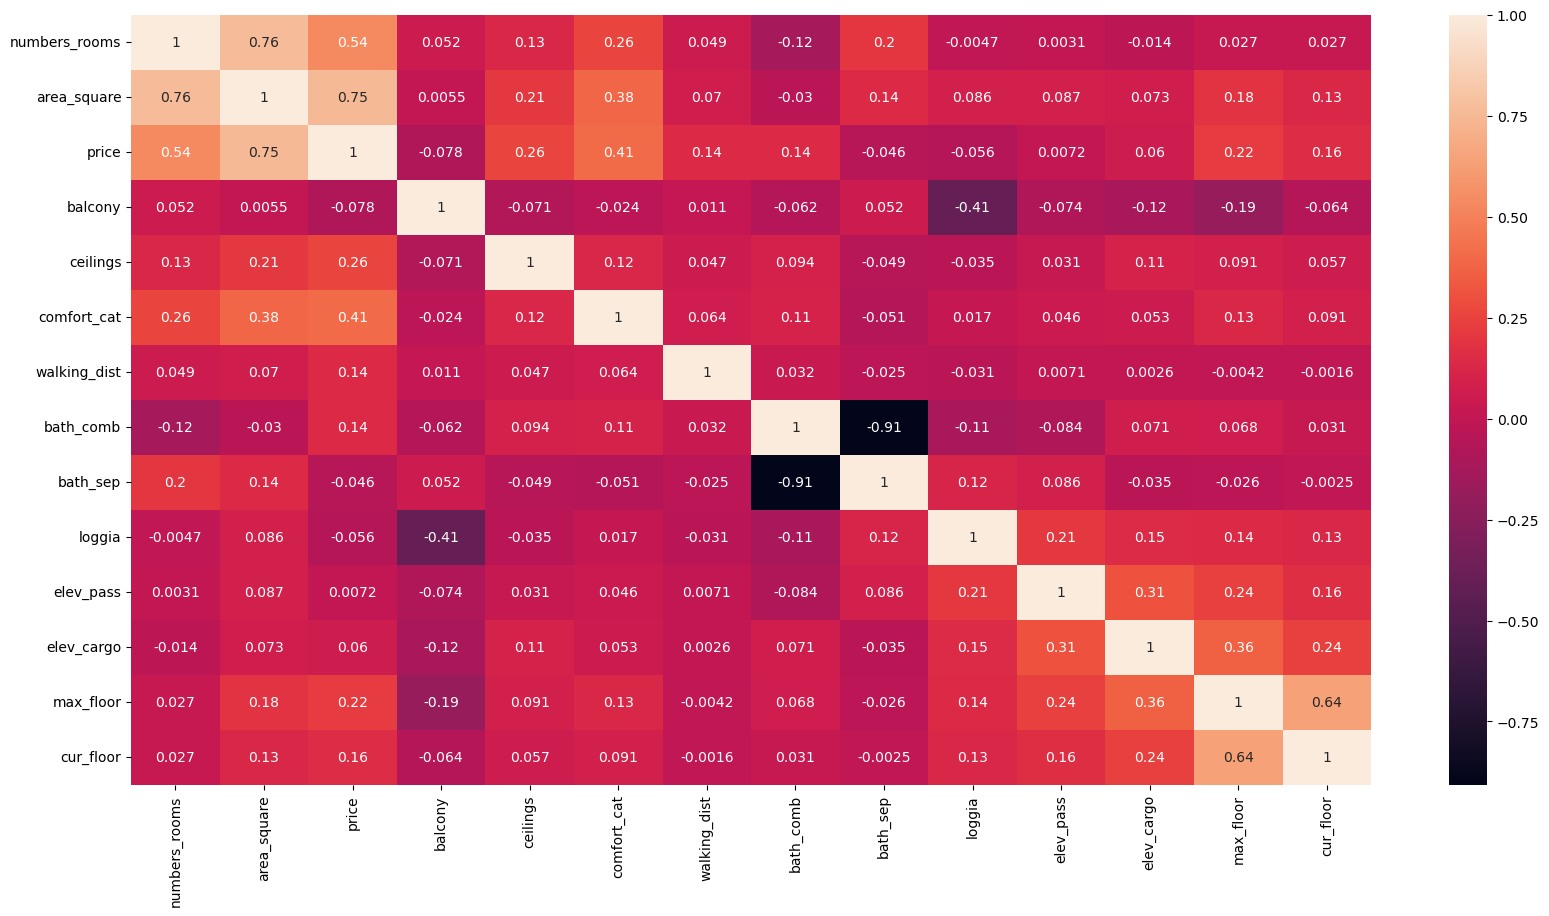

In [108]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(numeric_only=True), annot=True)

In [109]:
# Приступаем к кодированию категориальных данных

In [110]:
# Кодируем районы-кварталы

In [111]:
def classify_district(value):
    if value == 'CAO':
        return 1
    elif value == 'ZAO':
        return 0.60
    elif value == 'SAO':
        return 0.48
    elif value == 'SVAO':
        return 0.34
    elif value == 'RAYONI':
        return 0.24
    elif value == 'UAO':
        return 0.37
    elif value == 'UVAO':
        return 0.25
    elif value == 'UZAO':
        return 0.42
    elif value == 'SZAO':
        return 0.45
    elif value == 'VAO':
        return 0.29
    elif value == 'NAO':
        return 0.32

df['district'] = pd.to_numeric(df['district'].map(classify_district))

In [112]:
# Кодируем ремонт квартиры

In [113]:
def classify_repair(value):
    if value == 'Косметический':
        return 0.4
    elif value == 'Евроремонт':
        return 0.64
    elif value == 'Дизайнерский':
        return 1
    elif value == 'Без ремонта':
        return 0.44  

df['repair'] = pd.to_numeric(df['repair'].map(classify_repair))

In [114]:
# Кодируем типы домов

In [115]:
def classify_building(value):
    if value == ' Панельный':
        return 0.28
    elif value == ' Кирпичный':
        return 0.41
    elif value == ' Монолитный':
        return 0.50
    elif value == ' Блочный':
        return 0.26
    elif value == ' Монолитно-кирпичный':
        return 0.69
    elif value == ' Сталинский':
        return 0.56
    elif value == ' старый фонд':
        return 1


df['type_house'] = pd.to_numeric(df['type_house'].map(classify_building))

In [116]:
# Кодируем парковку

In [117]:
def classify_parking(value):
    if value == 'подземная':
        return 1
    elif value in ['наземная','открытая','нет парковки']:
        return 0.5
    elif value == 'многоуровневая':
        return 0.65

df['parking'] = pd.to_numeric(df.loc[:,'parking'].map(classify_parking))

In [118]:
# Преобразовываем bool в int или float

In [119]:
df['balcony'] = df['balcony'].astype(int)
df['comfort_cat'] = df['comfort_cat'].astype(int)
df['walking_dist'] = df['walking_dist'].astype(int)
df['bath_comb'] = df['bath_comb'].astype(int)
df['bath_sep'] = df['bath_sep'].astype(int)
df['loggia'] = df['loggia'].astype(int)
df['elev_pass'] = df['elev_pass'].astype(int)
df['elev_cargo'] = df['elev_cargo'].astype(int)

<Axes: >

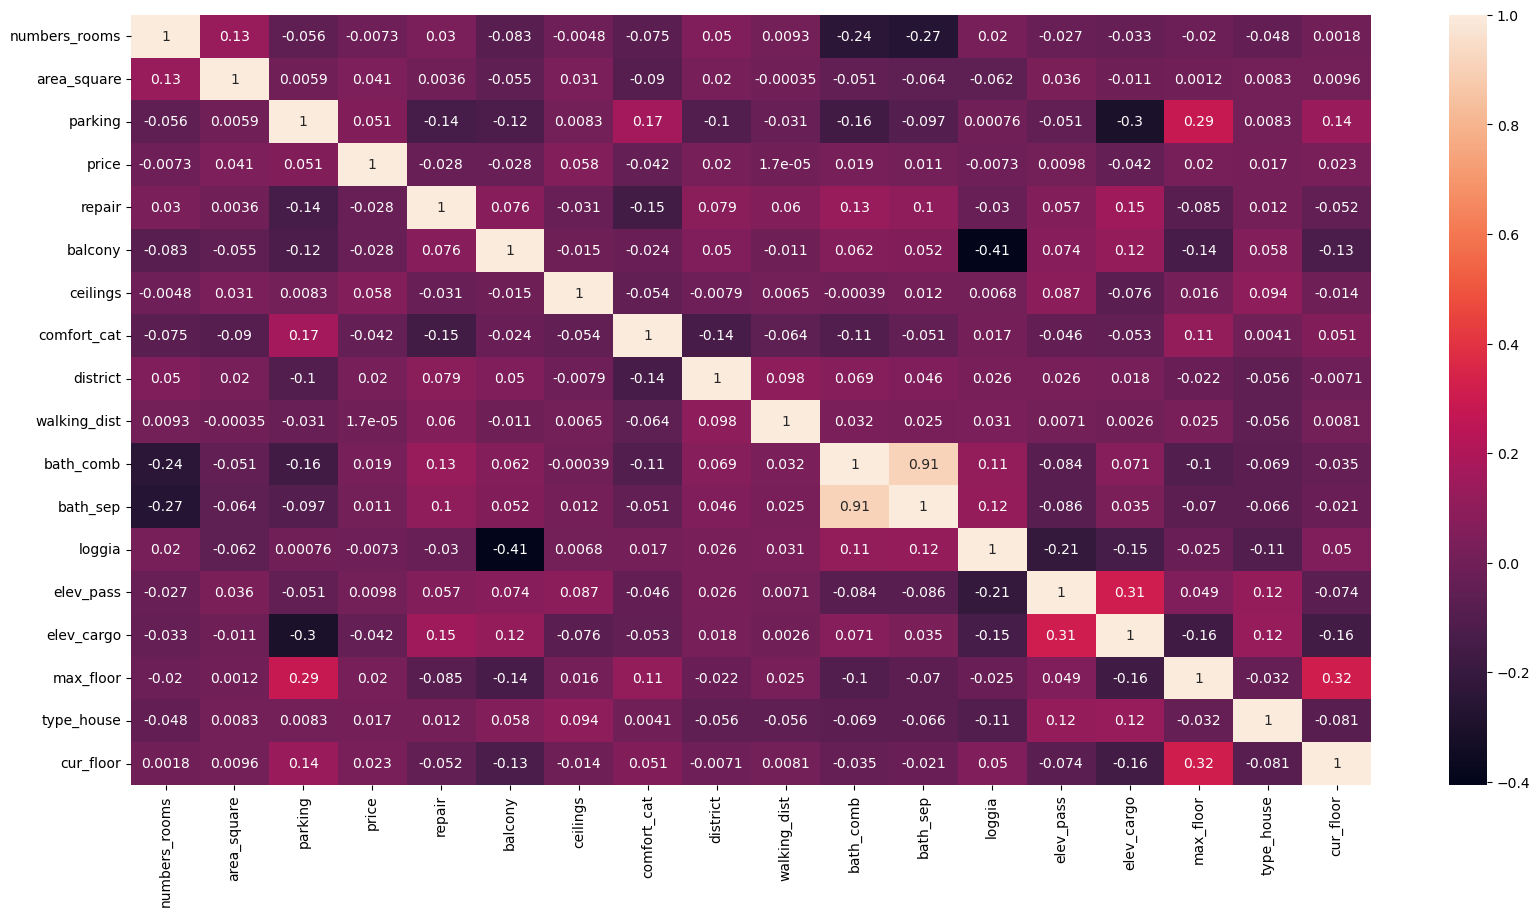

In [120]:
plt.figure(figsize=(20,10))
sns.heatmap(df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1), annot=True)

<Axes: >

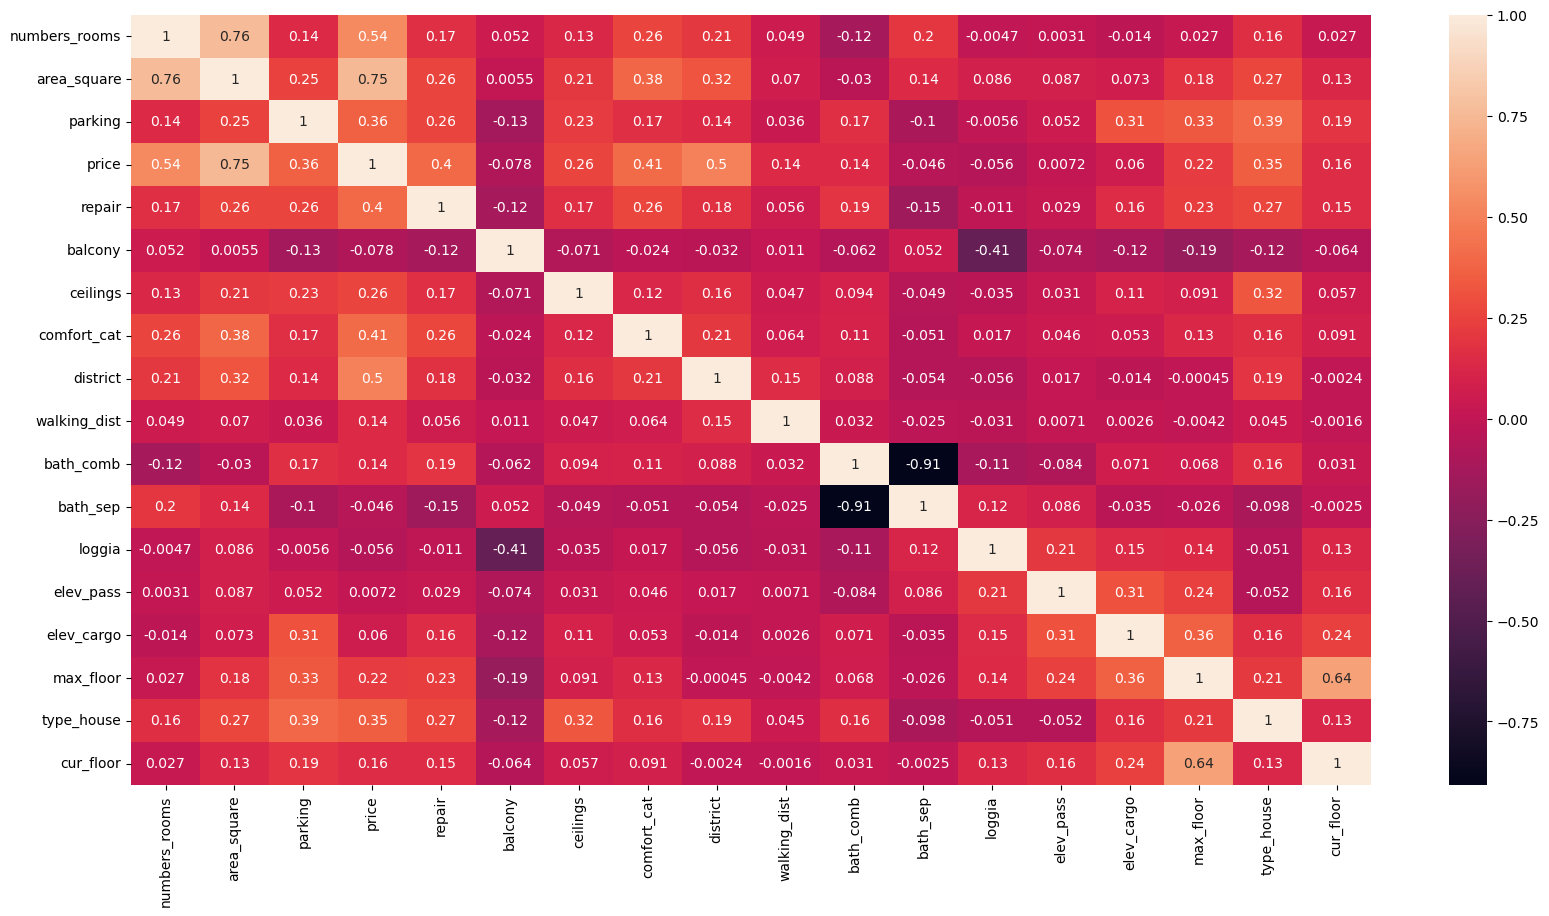

In [121]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(numeric_only=True), annot=True)

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18193 entries, 273614615 to 274672243
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   numbers_rooms  18193 non-null  int64  
 1   area_square    18193 non-null  int64  
 2   parking        18193 non-null  float64
 3   price          18193 non-null  int64  
 4   repair         18193 non-null  float64
 5   balcony        18193 non-null  int64  
 6   ceilings       18193 non-null  float64
 7   comfort_cat    18193 non-null  int64  
 8   district       18193 non-null  float64
 9   walking_dist   18193 non-null  int64  
 10  bath_comb      18193 non-null  int64  
 11  bath_sep       18193 non-null  int64  
 12  loggia         18193 non-null  int64  
 13  elev_pass      18193 non-null  int64  
 14  elev_cargo     18193 non-null  int64  
 15  max_floor      18193 non-null  int64  
 16  type_house     18193 non-null  float64
 17  cur_floor      18193 non-null  int64  
dtyp

In [123]:
df.head(10)

,numbers_rooms,area_square,parking,price,repair,balcony,ceilings,comfort_cat,district,walking_dist,bath_comb,bath_sep,loggia,elev_pass,elev_cargo,max_floor,type_house,cur_floor
ID объявления,,,,,,,,,,,,,,,,,,
273614615,2,58,0.5,225000,0.64,0,3.90,0,1.0,1,1,0,0,1,1,26,0.28,12
274475342,3,98,1.0,250000,0.64,0,3.20,0,1.0,1,1,1,0,1,0,4,0.50,2
273973191,3,120,0.5,130000,0.64,0,3.00,0,1.0,1,1,0,0,1,0,10,0.56,5
273999490,3,80,0.5,100000,0.64,1,2.64,0,1.0,1,1,0,0,1,0,8,0.41,4
274017037,3,100,0.5,200000,1.00,0,2.64,1,1.0,1,1,0,0,1,0,4,0.41,2
274995950,2,30,0.5,120000,0.64,0,2.64,1,1.0,1,1,0,0,0,0,26,0.28,19
273941734,2,64,0.5,205000,0.64,0,2.64,0,1.0,1,1,0,0,0,0,26,0.28,12
274493570,3,112,1.0,230000,0.64,1,3.20,1,0.6,1,1,0,0,1,0,7,0.28,2
272945376,3,100,0.5,200000,0.64,0,3.20,1,1.0,1,1,0,0,1,0,8,0.28,3


In [124]:
# выгружаем финальные данные

In [125]:
df.to_csv('plyushkiny_data.csv')